In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load cleaned dataset (Member 1's output)
cleaned_data = pd.read_csv("01.cleaned_telco_customer_data.csv")
print("Loaded cleaned data:", cleaned_data.shape)

# Work on a copy for integration
df = cleaned_data.copy()
df.head()


Loaded cleaned data: (55280, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST00001,Male,0,No,Yes,3.0428,Yes,Yes,No,No,...,No,No,No,No,Month-to-Month,No,Mailed check,71.907980,99.810180,Yes
1,CUST00002,Male,1,Yes,No,3.0428,Yes,Yes,DSL,No,...,No,Yes,Unknown,No,One year,Yes,Bank transfer (automatic),21.351177,99.810180,No
2,CUST00003,Female,0,No,No,36.8700,Yes,Yes,DSL,No,...,No,Unknown,Yes,Yes,Month-to-Month,No,Electronic check,41.157794,1727.307038,Yes
3,CUST00005,Male,1,Yes,Yes,14.1083,Yes,Unknown,Fiber optic,Yes,...,Yes,No,No,No,Two year,Yes,Electronic check,21.351177,324.789382,Yes
4,CUST00006,Male,0,Yes,No,20.0413,Yes,No,Fiber optic,No,...,Unknown,Yes,Unknown,No,One year,No,Electronic check,34.567089,556.898661,Yes


 1) Schema normalization (strings trimmed, numeric coercion)

In [3]:

print("Before normalization dtypes:\n", df.dtypes)

# Trim whitespace on object columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip()

# Ensure numeric columns are numeric
numeric_cols = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("\nAfter normalization dtypes:\n", df.dtypes[numeric_cols])


Before normalization dtypes:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

After normalization dtypes:
 SeniorCitizen       int64
tenure            float64
MonthlyCharges    float64
TotalCharges      float64
dtype: object


2) Entity identification: detect near-duplicate customerIDs and similar names

In [4]:
df = df.drop_duplicates(subset=["customerID"], keep="first").reset_index(drop=True)
print("Duplicates removed. Shape:", df.shape)

Duplicates removed. Shape: (55280, 21)


3) Value conflict resolution for Charges

In [5]:
# 3. Resolve TotalCharges conflicts (vectorized)
if set(["MonthlyCharges","tenure","TotalCharges"]).issubset(df.columns):
    derived = (df["MonthlyCharges"] * df["tenure"]).round(2)
    diff = (df["TotalCharges"] - derived).abs()
    conflict_mask = diff > np.maximum(1.0, 0.02 * derived)
    print("TotalCharges conflicts found:", conflict_mask.sum())

    # Correct by averaging existing and derived
    df.loc[conflict_mask, "TotalCharges"] = (
        (df.loc[conflict_mask, "TotalCharges"] + derived[conflict_mask]) / 2
    )

    df["TotalCharges"] = df["TotalCharges"].clip(lower=0)

TotalCharges conflicts found: 51516


4) Service logic: if InternetService == "No" -> set online/streaming/tech fields to "No"

In [6]:
df["InternetService"]

0                 No
1                DSL
2                DSL
3        Fiber optic
4        Fiber optic
            ...     
55275    Fiber optic
55276    Fiber optic
55277            DSL
55278    Fiber optic
55279             No
Name: InternetService, Length: 55280, dtype: object

In [7]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST00001,Male,0,No,Yes,3.0428,Yes,Yes,No,No,...,No,No,No,No,Month-to-Month,No,Mailed check,71.907980,159.305090,Yes
1,CUST00002,Male,1,Yes,No,3.0428,Yes,Yes,DSL,No,...,No,Yes,Unknown,No,One year,Yes,Bank transfer (automatic),21.351177,82.390090,No
2,CUST00003,Female,0,No,No,36.8700,Yes,Yes,DSL,No,...,No,Unknown,Yes,Yes,Month-to-Month,No,Electronic check,41.157794,1622.398519,Yes
3,CUST00005,Male,1,Yes,Yes,14.1083,Yes,Unknown,Fiber optic,Yes,...,Yes,No,No,No,Two year,Yes,Electronic check,21.351177,313.009691,Yes
4,CUST00006,Male,0,Yes,No,20.0413,Yes,No,Fiber optic,No,...,Unknown,Yes,Unknown,No,One year,No,Electronic check,34.567089,624.834330,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55275,CUST69995,Female,1,No,Yes,20.0413,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,One year,Yes,Electronic check,41.157794,825.317601,No
55276,CUST69997,Male,0,Yes,Unknown,14.1083,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-Month,Yes,Bank transfer (automatic),41.157794,568.784330,Yes
55277,CUST69998,Male,0,Unknown,No,20.0413,Yes,No,DSL,Yes,...,No,No,Unknown,No,Month-to-Month,Yes,Mailed check,27.997485,556.898661,No
55278,CUST69999,Male,0,No,No,20.0413,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-Month,Yes,Electronic check,48.184182,1069.366824,No


In [8]:
# 4. Service logic correction (vectorized)
if "InternetService" in df.columns:
    related = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
    mask_no_internet = df["InternetService"].str.lower().isin(["no", "none", "no internet service"])
    for c in related:
        if c in df.columns:
            changed = (df.loc[mask_no_internet, c] != "No").sum()
            df.loc[mask_no_internet, c] = "No"
            print(f"Changed {c} to 'No' for {changed} rows")

Changed OnlineSecurity to 'No' for 14 rows
Changed OnlineBackup to 'No' for 20 rows
Changed DeviceProtection to 'No' for 9 rows
Changed TechSupport to 'No' for 12 rows
Changed StreamingTV to 'No' for 15 rows
Changed StreamingMovies to 'No' for 13 rows


In [9]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST00001,Male,0,No,Yes,3.0428,Yes,Yes,No,No,...,No,No,No,No,Month-to-Month,No,Mailed check,71.907980,159.305090,Yes
1,CUST00002,Male,1,Yes,No,3.0428,Yes,Yes,DSL,No,...,No,Yes,Unknown,No,One year,Yes,Bank transfer (automatic),21.351177,82.390090,No
2,CUST00003,Female,0,No,No,36.8700,Yes,Yes,DSL,No,...,No,Unknown,Yes,Yes,Month-to-Month,No,Electronic check,41.157794,1622.398519,Yes
3,CUST00005,Male,1,Yes,Yes,14.1083,Yes,Unknown,Fiber optic,Yes,...,Yes,No,No,No,Two year,Yes,Electronic check,21.351177,313.009691,Yes
4,CUST00006,Male,0,Yes,No,20.0413,Yes,No,Fiber optic,No,...,Unknown,Yes,Unknown,No,One year,No,Electronic check,34.567089,624.834330,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55275,CUST69995,Female,1,No,Yes,20.0413,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,One year,Yes,Electronic check,41.157794,825.317601,No
55276,CUST69997,Male,0,Yes,Unknown,14.1083,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-Month,Yes,Bank transfer (automatic),41.157794,568.784330,Yes
55277,CUST69998,Male,0,Unknown,No,20.0413,Yes,No,DSL,Yes,...,No,No,Unknown,No,Month-to-Month,Yes,Mailed check,27.997485,556.898661,No
55278,CUST69999,Male,0,No,No,20.0413,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-Month,Yes,Electronic check,48.184182,1069.366824,No


5) Redundancy detection: correlation matrix, heatmap, drop very-highly-correlated (>0.98)

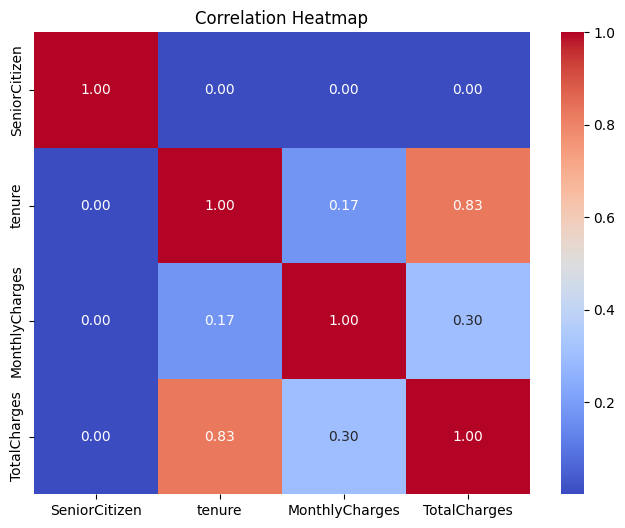

Dropped redundant columns: []


In [10]:
# 5. Redundancy detection via correlation
num_df = df.select_dtypes(include=[np.number])
if num_df.shape[1] >= 2:
    corr = num_df.corr().abs()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

    # Drop redundant (>0.98 correlation)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [c for c in upper.columns if any(upper[c] > 0.98) and c not in ["tenure", "TotalCharges", "MonthlyCharges"]]
    df = df.drop(columns=to_drop)
    print("Dropped redundant columns:", to_drop)


In [11]:
# 6) Final schema enforcement & cleanup, show head, save final integrated dataset

# Ensure categorical fields are strings and numeric fields floats
for c in df.columns:
    if c == 'tenure':
        # If tenure values are all integers, convert to Int64, else keep as float
        if (df[c].dropna() == df[c].dropna().astype(int)).all():
            df[c] = pd.to_numeric(df[c], errors='coerce').astype('Int64')
        else:
            df[c] = pd.to_numeric(df[c], errors='coerce').astype(float)
    elif df[c].dtype == object:
        df[c] = df[c].astype(str)
    elif pd.api.types.is_integer_dtype(df[c]) or pd.api.types.is_float_dtype(df[c]):
        df[c] = pd.to_numeric(df[c], errors='coerce').astype(float)

# Keep derived_TotalCharges if you want audit info, else drop:
# df = df.drop(columns=['derived_TotalCharges', 'total_diff_abs', 'total_conflict'], errors='ignore')


In [12]:
# Handle remaining NaN values
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())
print("Remaining NaN values:\n", df.isnull().sum())

Remaining NaN values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [13]:

# Drop helper normalization column if you don't want it saved
if 'name_norm' in df.columns:
    df = df.drop(columns=['name_norm'])


In [14]:
print("Final dataframe shape:", df.shape)
display(df.head())

Final dataframe shape: (55280, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST00001,Male,0.0,No,Yes,3.0428,Yes,Yes,No,No,...,No,No,No,No,Month-to-Month,No,Mailed check,71.907980,159.305090,Yes
1,CUST00002,Male,1.0,Yes,No,3.0428,Yes,Yes,DSL,No,...,No,Yes,Unknown,No,One year,Yes,Bank transfer (automatic),21.351177,82.390090,No
2,CUST00003,Female,0.0,No,No,36.8700,Yes,Yes,DSL,No,...,No,Unknown,Yes,Yes,Month-to-Month,No,Electronic check,41.157794,1622.398519,Yes
3,CUST00005,Male,1.0,Yes,Yes,14.1083,Yes,Unknown,Fiber optic,Yes,...,Yes,No,No,No,Two year,Yes,Electronic check,21.351177,313.009691,Yes
4,CUST00006,Male,0.0,Yes,No,20.0413,Yes,No,Fiber optic,No,...,Unknown,Yes,Unknown,No,One year,No,Electronic check,34.567089,624.834330,Yes


In [16]:
# Save integrated file with exact filename requested
out_path = "02.integrated_telco_data.csv"
df.to_csv(out_path, index=False)
print(f"Integrated dataset saved as: {out_path}")


Integrated dataset saved as: 02.integrated_telco_data.csv
